# A model for the effect of Degree of Linear Polarization on Dung Beetle Orientation Accuracy
---

## Details

&ensp;AUTHOR:&emsp;   James Foster &emsp; 2025 03 26

MODIFIED:&emsp; James Foster &emsp; 2025 08 11

DESCRIPTION:&emsp; Fit a hierarchical maximum-likelihood von Mises to dung beetle exit angles under a rotatable polarized light stimulus.
Modified from [beetles.ipynb](https://github.com/jgraving/unwrap/notebooks/)

            
INPUTS:&emsp;   `'DLdata201611.csv'`
            
OUTPUTS:&emsp;  Plots and test statistics

CHANGES: 
- Added 0.32 condition to positive control
- Changed prior on individual mu to Normal
- Made categorical DoLP model
- Made linear DoLP model
- Added (imitation) original model
- Added model comparison
- Attempt bimodal model with custom family

REFERENCES:
- Foster, J.J., $et~al$.  (2019). 
Orienting to polarized light at night – matching lunar skylight to performance in a nocturnal beetle.
Journal of Experimental Biology 222, jeb188532. 
DOI:[10.1242/jeb.188532](https://doi.org/10.1242/jeb.188532)

- Sayin S, ... Graving JM, $et~al$. (2025)
The behavioral mechanisms governing collective motion in swarming locusts.
Science 387,995-1000
DOI:[10.1126/science.adq7832](https://doi.org/10.1126/science.adq7832)

- Graving JM & Foster JJ (in preparation)
Unwrapping Circular Statistics: Bayesian Linear Models for Circular Data

---
# TODO
>- Try looser priors for max polarization condition +
>- Compare circular uniform and unimodal priors +
>- Combine DoLP 0.99 and 0.32 conditions +
>- Try restrictive empirical priors +
>- Try normal priors +
>- Find appropriate priors for the 90° turn +
>- Test model with categorical DoLP +
>- Test model with linear DoLP + 
>- Test model with log10 DoLP +
>- Test model with logit DoLP +
>- Test 2019 model  +
>- Reset circular effects of DoLP to categorical
- Test effects of night
- Test bimodal model
- Check data order

In [1]:
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install -U --no-cache git+https://github.com/jgraving/unwrap

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to c:\users\james foster\appdata\local\temp\pip-req-build-se0t1tyf
  Resolved https://github.com/jgraving/unwrap to commit 00e212a180d0fbde4ce5aa40e7818def362d5117
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=12160 sha256=3a05cb484dc07f5bee73fbbb02a4f8398a1749d191be2634f1e4f4d929a2414a
  Stored in directory: C:\Users\James Foster\AppData\Local\Temp\pip-ephem-wheel-cache-hjui3y06\wheels\6d\a6\84\e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap 'C:\Users\James Foster\AppData\Local\Temp\pip-req-build-se0t1tyf'


# Reorganise data for modelling
The original data was in a wide format with separate columns for the angle observed in trials 1 and 2,
as well as for the different conditions in trials 1 and 2.

Here we separate them, convert condition names to condition features, and convert angles from degrees to radians.

In [2]:
import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'DLdata201611.csv'
df_raw = pd.read_csv(file_path, sep=',')
#Columns
#night	trial1	trial2	cond1	cond2	deg.of.pol	Beetle

# Data is in wide format, convert from wide to long
df = pd.wide_to_long(df_raw,
                          stubnames= ['trial','cond'], #find columns starting with these labels
                          i = 'Beetle', #organise by beetle
                          j = 'Trial') #assign trial to a new column called "Trial"
#Convert Beetle and Trial from indices to column names
df = df.reset_index(level = ['Beetle', 'Trial']) #After conversion saves as separate index columns
# #Rename variables for BAMBI
df = df.rename(columns={'trial': 'deg_angle'}) #save output from each trial column as the angle
df = df.rename(columns={'deg.of.pol': 'DoLP'}) #capitalise DoLP
df = df.rename(columns={'night': 'Night'}) #Captitalise
df = df.rename(columns={'Beetle': 'Individual'}) #More specific name NB very likely some are the same indiv multiple times

# Specify circular data
df['RadAngle'] = np.deg2rad(df['deg_angle']) #convert to radians
# Normalize the heading radians to be between -pi and pi
df['RadAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# # Specify condition types by rotation angle
df['PolAngle'] = df['cond'].apply(
    lambda x: 
    0 if 'PolNorth' in x else 
     0 if 'UnpolNorth' in x else 90)
df['PolAngle_rad'] = np.deg2rad(df['PolAngle']) #convert to radians


# # Rename columns: change 'Beetle' to 'Individual'
df['Individual'] = df['Individual'].astype('category')
df['Night'] = df['Night'].astype('category')

# # Keep only the relevant columns and drop rows with missing values
df = df[['Individual', 'Trial', 'DoLP', 'PolAngle_rad', 'Night', 'RadAngle', 'deg_angle']].dropna().copy()
df.reset_index(drop=True, inplace=True)

df.head(n = 345)

Individual  Trial  DoLP  PolAngle_rad     Night  RadAngle  deg_angle
0            1      1  0.99      0.000000  20161111 -2.094395        240
1            2      1  0.02      0.000000  20161111  2.268928        130
2            3      1  0.99      1.570796  20161111  1.047198         60
3            4      1  0.02      1.570796  20161111 -0.785398        315
4            5      1  0.99      0.000000  20161111  1.570796         90
..         ...    ...   ...           ...       ...       ...        ...
340          1      2  0.99      1.570796  20161111 -1.919862        250
341          2      2  0.02      1.570796  20161111 -1.832596        255
342          3      2  0.99      0.000000  20161111  0.261799         15
343          4      2  0.02      0.000000  20161111 -2.007129        245
344          5      2  0.99      1.570796  20161111  0.349066         20

[345 rows x 7 columns]

# Inspect the data

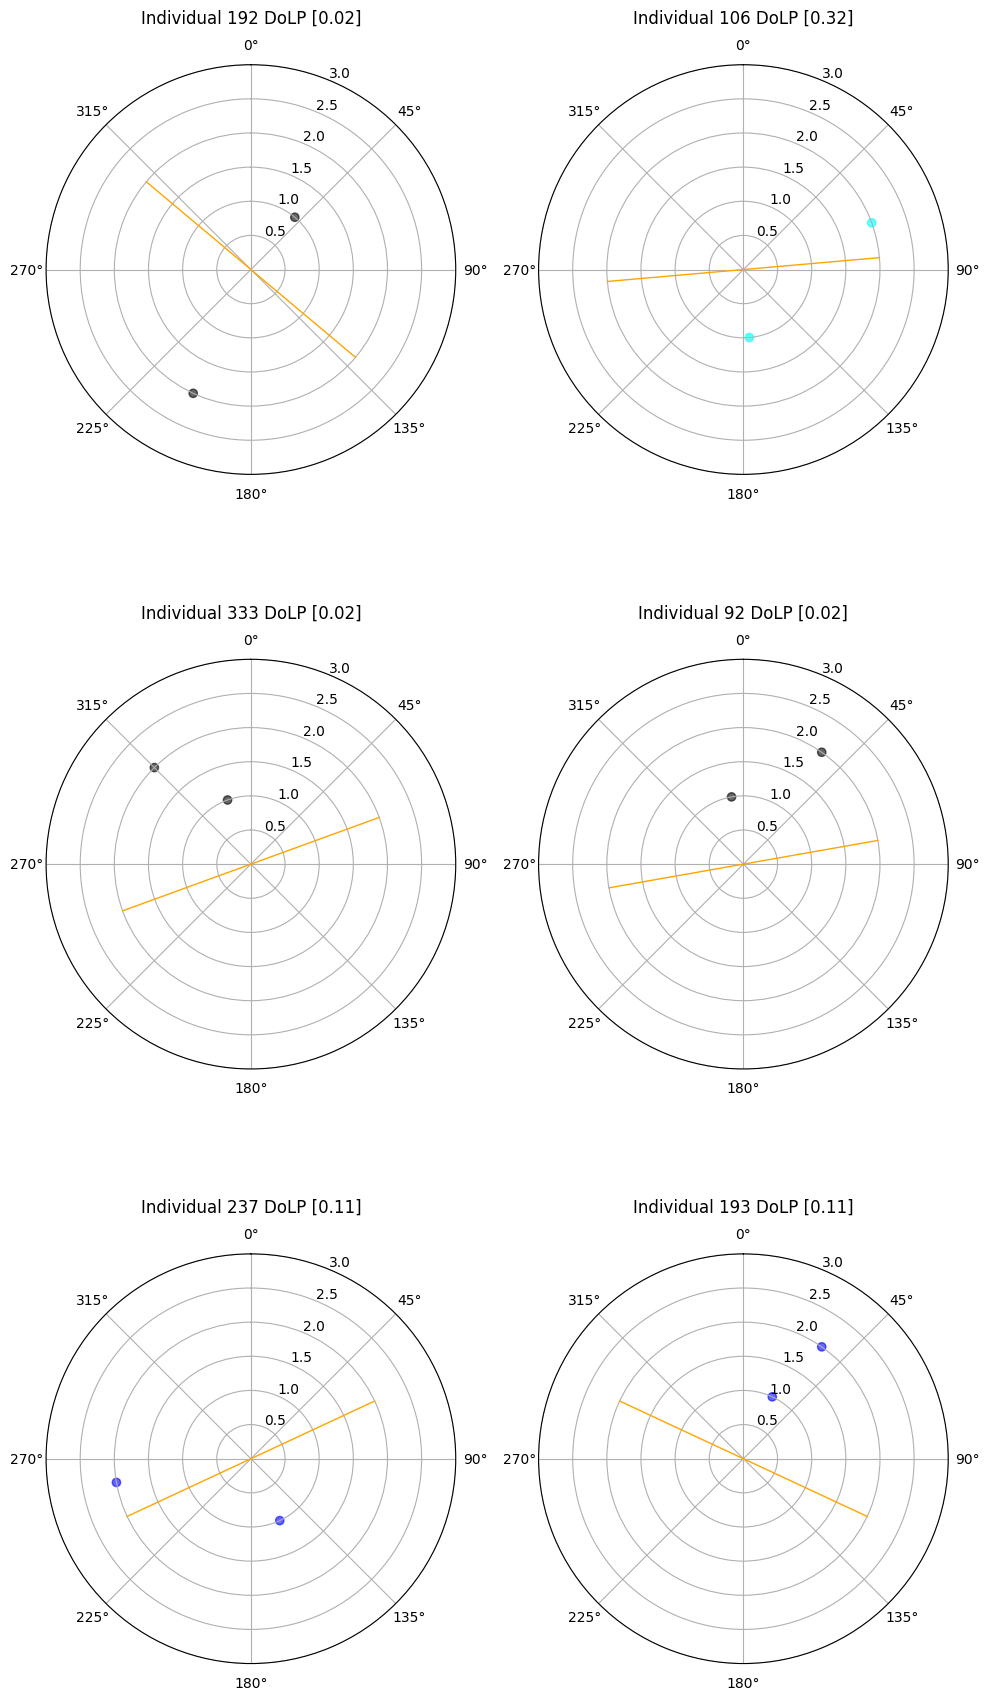

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()
unique_individuals = unique_individuals[np.random.randint(low = 0, high=340, size=6)] # just six chosen randomly

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = ( np.intc(np.ceil(n_plots/2)) , 2  ) # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = np.max(df['Trial'])  # Maximum radial value (maximum runs)  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    # Set axes to geographic format (clockwise, 0° at the top)
    ax.set_theta_zero_location('N')#place 0° at the top
    ax.set_theta_direction(-1)#reverse to clockwise

    individual_data = df[df['Individual'] == individual]
    individual_data = df[df['Individual'] == individual]
    plotcol = individual_data['DoLP'].apply(
                     lambda x: 'red' if x  == 0.99 else
                                'cyan' if x == 0.32 else
                                 'blue' if x == 0.11 else
                                 'darkblue' if x == 0.04 else
                                 'black')

    # Scatter-plot data.
    plot_scatter(ax, individual_data, 'RadAngle', 'Trial', 
                 plotcol, individual_data['DoLP'])
    #Add expected axis for 2nd trial
    ax.plot(individual_data['RadAngle'].values[0]+[-np.pi/2, np.pi/2], [radial_max, radial_max], color='orange', linewidth=1)
    
    # Plot summary statistics for each condition.
    # if not individual_data.empty:
    #     plot_summary_stats(individual_data, individual_data['RadAngle'].values, radial_max, 'gray')
    
    ax.set_title(f'Individual {individual} DoLP {np.unique(individual_data['DoLP'])}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)


plt.tight_layout()
plt.show()


# Fit a circular model with individual effects but no interactions
The model needs to predict a bimodal distribution with changes of 90° between trials 

In [4]:
# import sys
# !{sys.executable} -m pip install fastprogress
# import sys
# !{sys.executable} -m pip install ipywidgets

## First test: Positive control


In [5]:
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior
# from unwrap.distributions import BimodalVonMises
from pymc import VonMises

from scipy.stats import vonmises, circstd


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)
df.head(n = 345)
# #1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
df_max = df[df['DoLP'] > 0.90 ] #Just the maximum polarization
# df_max = df[df['DoLP'] > 0.31 ] #20250327 add the 2nd most polarized condition to get more data to fit to

# Use MLE estimates of one condition to find good priors for individual effects (each represents one trial per animal)
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
vm_prior = vonmises.fit(condata["TwoAngle"], fscale=1) #MLE von Mises fit to dist of individuals
sd_prior = circstd(condata["TwoAngle"]) #Mardia SD used as estimate of normal SD

# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "TwoAngle ~ Cond + (1|Individual)",
    "kappa ~ 1 + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats, but fixed with normal prior on individual directions
# 2 trials per individual may be insufficient to estimate individual effects in this way
priors = {
    # Fixed effects for μ:
    # "Intercept": CircularUniformPrior(), # Unbiased prior, pop mean can be in any direction
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    # Restrictive von Mises works, but still has some convergence problems
    # "Intercept": bmb.Prior("VonMises", mu=vm_prior[1], kappa=300.0), 
    # Normal version converges smoother
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=3*np.pi/180), 
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=90*np.pi/180), #
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # Informative prior used expecting SD close to that measured empirically
    # Using a normal distribution because that converges better
    "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.1) #assume the ML estimate is correct
    # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(sd_prior), sigma=0.1) #assume the ML estimate is correct
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        #20250327 try higher precision to make individual mean directions easier to estimate
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
model = bmb.Model(
    formula,
    df_max,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(model)

# Fit the model.
# 4000 iterations takes approx 90s
idata = model.fit(draws= 2000,
                  tune = 2000,
                  init = 'auto',
                  progressbar=True) # 

       Formula: TwoAngle ~ Cond + (1|Individual)
                kappa ~ 1 + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.3222, sigma: 0.0524)
            Cond ~ Normal(mu: 3.1416, sigma: 1.5708)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: StudentT(nu: 3.0, mu: 2.3845, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
C:\Users\James Foster\AppData\Roaming\Python\Python312\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_1|Individual

Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 79 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics

In [6]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "Cond",
                "kappa_Intercept",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                -0.329  0.052  -0.428   -0.232      0.002    0.000   
1|Individual_sigma        2.342  0.128   2.077    2.574      0.009    0.007   
Cond[1.5707963267948966] -2.795  0.143  -3.073   -2.537      0.007    0.002   
kappa_Intercept           3.307  0.474   2.427    4.196      0.007    0.005   
kappa_1|Individual_sigma  0.510  0.051   0.417    0.610      0.000    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   6964.0    6029.0   1.00  
1|Individual_sigma           189.0    1468.0   1.02  
Cond[1.5707963267948966]    1940.0    4017.0   1.01  
kappa_Intercept             5036.0    5890.0   1.00  
kappa_1|Individual_sigma   16130.0    6052.0   1.00

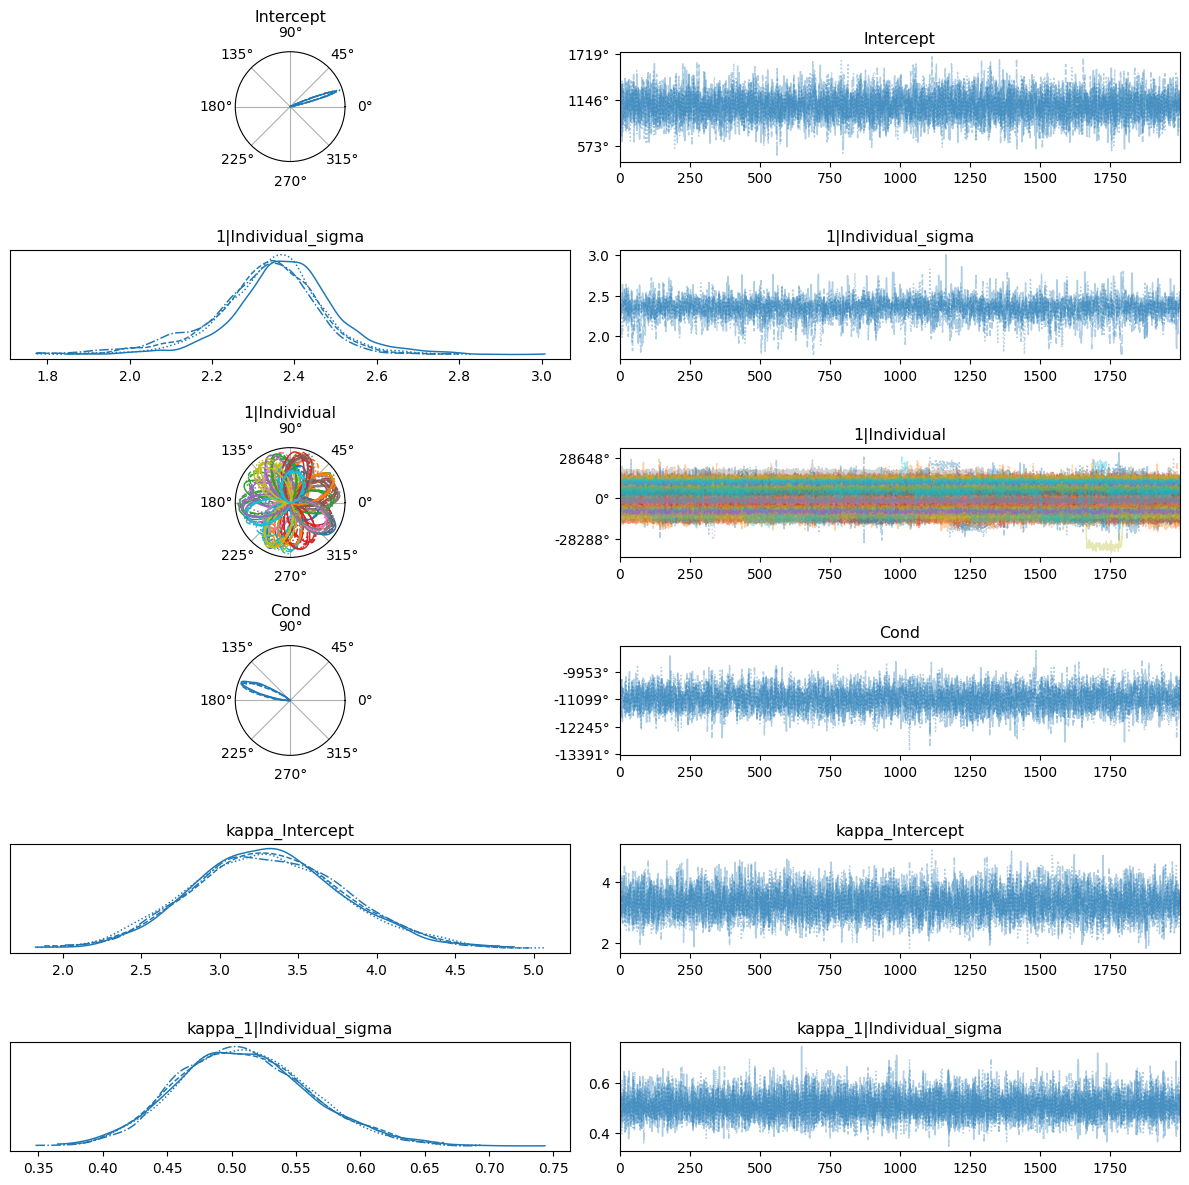

In [7]:
varnms = ["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
               "1|Individual",
                "Cond",
                "kappa_Intercept",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
cvars = ["Intercept",
        "Cond",
        "1|Individual",
        #  "1|Individual_sigma", # fun to plot on a circular scale, but hard to identify problems
        ]
#transform the circular data for interpretability
idata_trans = idata.copy() # set up a variable for transformed data
for cvar in cvars:
    idata_trans.posterior[cvar] = -180*idata_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_trans,
              var_names=varnms,
              circ_var_names=cvars,
              circ_var_units='degrees') #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Catergorical model for effect of DoLP
Check effect of different DoLP conditions, without fitting a linear relationship

In [8]:
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from pymc import VonMises

from scipy.stats import vonmises, circstd


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)
#1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
#1st test DoLP as categorical
df['catDoLP'] = pd.Categorical(df['DoLP'],
                                categories=[0.99, #hopefully this will be the intercept condition
                                            0.32,
                                            0.11,
                                            0.04,
                                            0.02],
                                ordered=True)
# df.head()
# df['catDoLP']
# Use MLE estimates of one condition to find good priors for individual effects (each represents one trial per animal)
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
vm_prior = vonmises.fit(condata["TwoAngle"], fscale=1) #MLE von Mises fit to dist of individuals
sd_prior = circstd(condata["TwoAngle"]) #Mardia SD used as estimate of normal SD

# Define the model formula with updated, capitalized variable names.
cat_formula = bmb.Formula(
    "TwoAngle ~ Cond + catDoLP + (1|Individual)",
    "kappa ~ catDoLP + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats, but fixed with normal prior on individual directions
# 2 trials per individual may be insufficient to estimate individual effects in this way
cat_priors = {
    # Fixed effects for μ:
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    # Normal version converges smoother
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=1*np.pi/180), 
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=60*np.pi/180), #
    # No expectations about different mean headings by condition, beyond a wider spread
    "catDoLP": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180), #
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # Informative prior used expecting SD close to that measured empirically
    # Using a normal distribution because that converges better
    "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma = sd_prior/4) #assume zero, but scale by ML estimate
    # "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.1) #assume the ML estimate is correct
    # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(sd_prior), sigma=0.1) #assume the ML estimate is correct
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        #20250327 try higher precision to make individual mean directions easier to estimate
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        "catDoLP": bmb.Prior("Normal", mu=0, sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
cat_model = bmb.Model(
    cat_formula,
    df,
    family="vonmises",
    priors=cat_priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(cat_model)

# Fit the model.
# 4000 iterations takes approx 120s
cat_idata = cat_model.fit(
                draws= 1000,
                tune = 1000,
                init = 'auto',
                progressbar=True) # 

       Formula: TwoAngle ~ Cond + catDoLP + (1|Individual)
                kappa ~ catDoLP + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 680
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.3222, sigma: 0.0175)
            Cond ~ Normal(mu: 3.1416, sigma: 1.0472)
            catDoLP ~ Normal(mu: 0.0, sigma: 0.5236)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 0.5961))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
            kappa_catDoLP ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, catDoLP, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_catDoLP, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 135 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics

In [9]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    cat_idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_catDoLP",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    "catDoLP",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                -0.322  0.017  -0.355   -0.291      0.000    0.000   
1|Individual_sigma        2.286  0.337   1.719    2.949      0.096    0.069   
Cond[1.5707963267948966] -2.949  0.178   2.992   -2.623      0.013    0.006   
catDoLP[0.32]             0.037  0.566  -1.020    1.099      0.063    0.063   
catDoLP[0.11]             0.029  0.542  -0.952    1.080      0.025    0.019   
catDoLP[0.04]             0.158  0.544  -0.853    1.206      0.019    0.015   
catDoLP[0.02]            -0.041  0.504  -0.959    0.934      0.015    0.014   
kappa_Intercept           1.978  0.330   1.382    2.632      0.008    0.006   
kappa_catDoLP[0.32]      -0.914  0.548  -1.880    0.156      0.015    0.011   
kappa_catDoLP[0.11]      -1.554  0.569  -2.602   -0.453      0.014    0.010   
kappa_catDoLP[0.04]      -2.143  0.588  -3.325   -1.115      0.017    0.012   
kappa_catDoLP[0.02]      -2.651  0.511  -3.658   -1.752      0.016    0.011   
kappa_1|Individual_sigma  0.500  0.050   0.406    0.591      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   8007.0    3307.0   1.00  
1|Individual_sigma            13.0      41.0   1.26  
Cond[1.5707963267948966]     411.0    1439.0   1.02  
catDoLP[0.32]                 41.0     186.0   1.08  
catDoLP[0.11]                390.0     919.0   1.01  
catDoLP[0.04]                628.0    1572.0   1.01  
catDoLP[0.02]                662.0    1561.0   1.01  
kappa_Intercept             1698.0    2420.0   1.00  
kappa_catDoLP[0.32]         1317.0    1862.0   1.00  
kappa_catDoLP[0.11]         1657.0    2803.0   1.00  
kappa_catDoLP[0.04]         1201.0    2699.0   1.00  
kappa_catDoLP[0.02]         1041.0    2226.0   1.00  
kappa_1|Individual_sigma    6260.0    2636.0   1.00

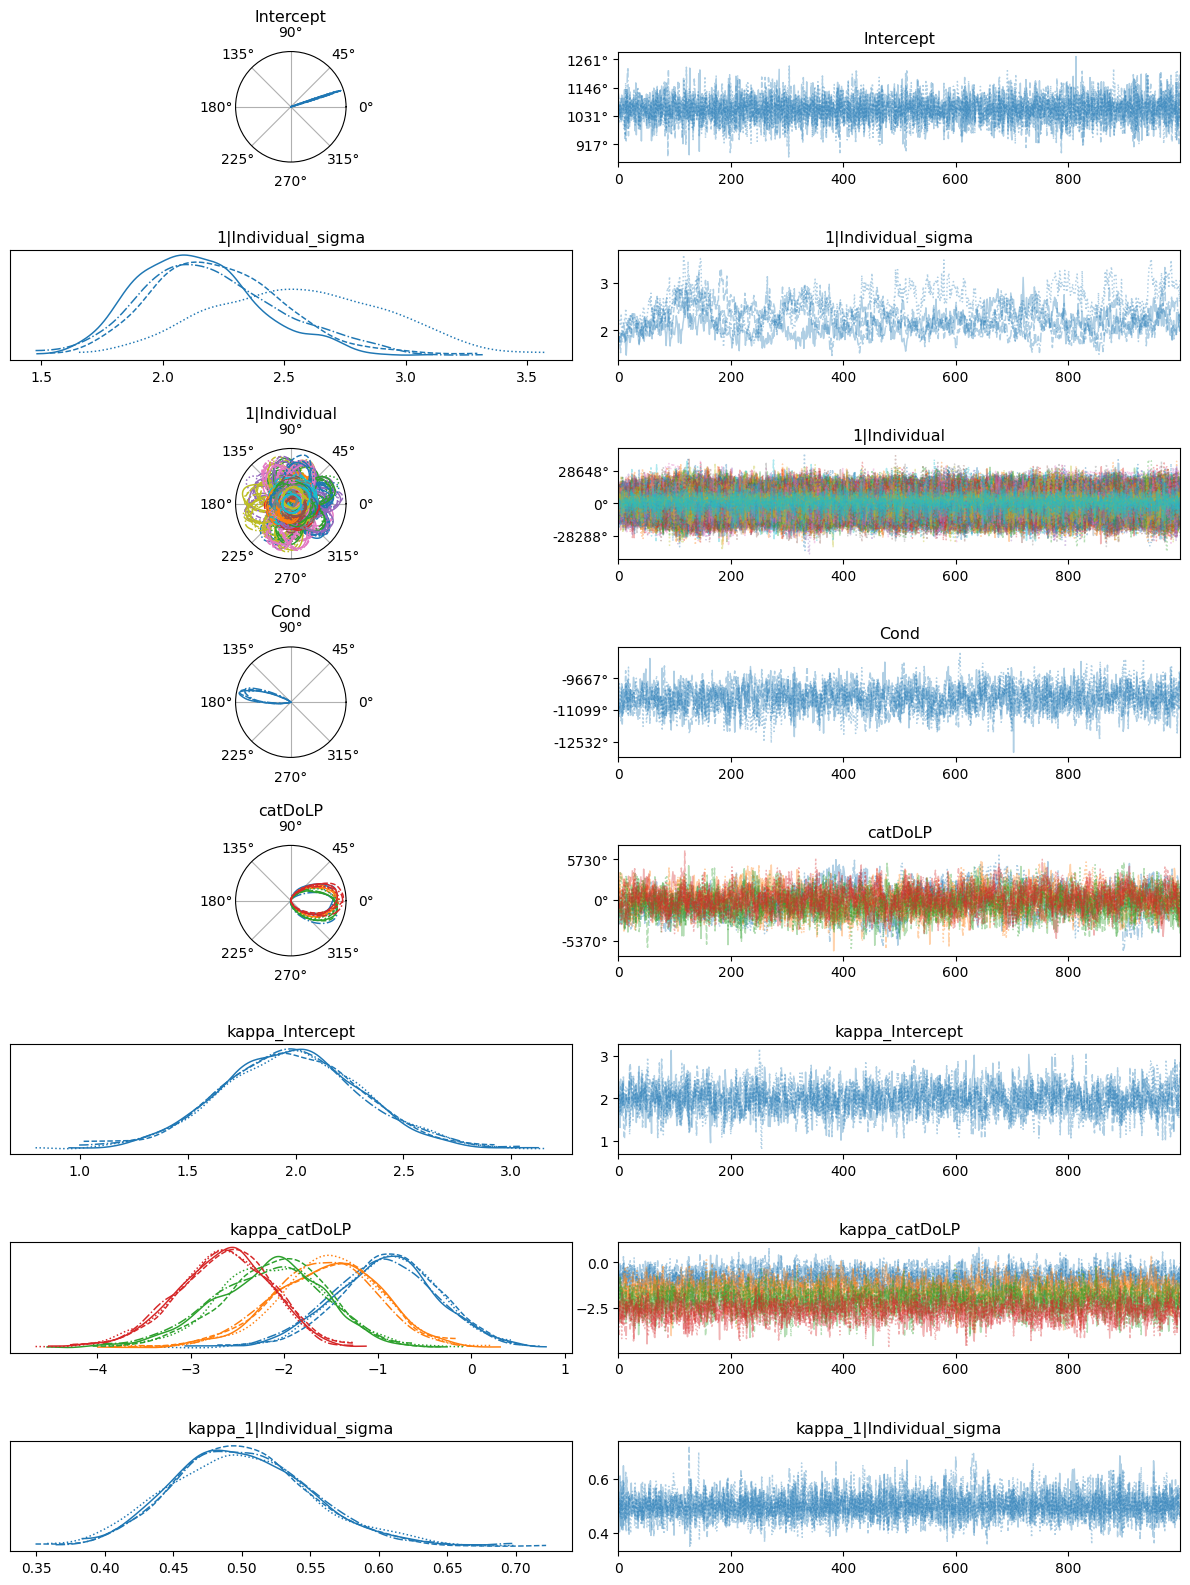

In [10]:
cat_varnms = ["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
               "1|Individual",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_catDoLP",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
cat_cvars = ["Intercept",
             "1|Individual",
             #  "1|Individual_sigma", # fun to plot on a circular scale, but hard to identify problems
                    "Cond",
                    "catDoLP",
        ]
#transform the circular data for interpretability
cat_idata_trans = cat_idata.copy() # set up a variable for transformed data #20250327 somehow linked to old variable!
for cvar in cat_cvars:
    cat_idata_trans.posterior[cvar] = -180*cat_idata.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(cat_idata_trans,
              var_names=cat_varnms,
              circ_var_names=cat_cvars,
              circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model with linear effect of (negative) DoLP

In [11]:
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from pymc import VonMises

from scipy.stats import vonmises, circstd


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)

#2nd test, inverse DoLP so that 0 == maximum kappa (potentially easier intercept condition)
df['invDoLP'] = df['DoLP'].apply(lambda x: -(1-x)) #intention: 0.99 -> -0.01; 0.02 -> -0.98
#1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
# Use MLE estimates of one condition to find good priors for individual effects (each represents one trial per animal)
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
vm_prior = vonmises.fit(condata["TwoAngle"], fscale=1) #MLE von Mises fit to dist of individuals
sd_prior = circstd(condata["TwoAngle"]) #Mardia SD used as estimate of normal SD

# Define the model formula with updated, capitalized variable names.
# for the angle, it might still be better to use the categorical degree of polarization, this may not scale linearly
neg_formula = bmb.Formula(
    "TwoAngle ~ Cond + catDoLP + (1|Individual)",
    "kappa ~ invDoLP + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats, but fixed with normal prior on individual directions
# 2 trials per individual may be insufficient to estimate individual effects in this way
neg_priors = {
    # Fixed effects for μ:
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    # Normal version converges smoother
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=1*np.pi/180), 
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=60*np.pi/180), #
    # No expectations about different mean headings by DoLP, beyond a wider spread
    "catDoLP": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180), #could be wider, as 1.0 includes the entire range of DoLP
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # 20250328 noticed multimodality in the posterior, much larger option also found. Try less restrictive?
    # Informative prior used expecting SD close to that measured empirically
    # Using a normal distribution because that converges better
    "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma = sd_prior/4) #assume zero, but scale by ML estimate
    # "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.1) #assume the ML estimate is correct #assume the ML estimate is correct
    # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(sd_prior), sigma=0.07) #assume the ML estimate is correct
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        #20250327 try higher precision to make individual mean directions easier to estimate
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        "invDoLP": bmb.Prior("Normal", mu=0, sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
neg_model = bmb.Model(
    neg_formula,
    df,
    family="vonmises",
    priors=neg_priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(neg_model)

# Fit the model.
# 4000 iterations takes approx 180s
neg_idata = neg_model.fit(
                draws= 1000,
                tune = 1000,
                init = 'auto',
                progressbar=True) # 

       Formula: TwoAngle ~ Cond + catDoLP + (1|Individual)
                kappa ~ invDoLP + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 680
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.3222, sigma: 0.0175)
            Cond ~ Normal(mu: 3.1416, sigma: 1.0472)
            catDoLP ~ Normal(mu: 0.0, sigma: 0.5236)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 0.5961))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
            kappa_invDoLP ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, catDoLP, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_invDoLP, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 308 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics
We expect an intercept kappa of around 3 and a coefficient for `invDoLP` > 3, which would suggest that with a decrease in DoLP of 1.0 _kappa_ begins to approach zero. In practice with 2 trials it is difficult to measure _kappa_ = `0`. In the original publication, _kappa_ was estimated to be approximately `0.2` for DoLP of `0.0`.

In [12]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    neg_idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_invDoLP",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    "catDoLP",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                -0.323  0.017  -0.354   -0.290      0.000    0.000   
1|Individual_sigma        3.940  3.324   1.545   10.227      1.640    1.254   
Cond[1.5707963267948966] -2.868  0.151   3.124   -2.590      0.009    0.003   
catDoLP[0.32]             0.045  0.522  -0.912    1.061      0.042    0.022   
catDoLP[0.11]            -0.059  0.554  -1.043    0.990      0.017    0.013   
catDoLP[0.04]             0.157  0.532  -0.859    1.129      0.040    0.025   
catDoLP[0.02]             0.010  0.486  -0.915    0.916      0.008    0.014   
kappa_Intercept           2.698  0.376   2.027    3.428      0.008    0.006   
kappa_invDoLP             3.348  0.504   2.434    4.307      0.012    0.009   
kappa_1|Individual_sigma  0.503  0.050   0.414    0.601      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   7960.0    2771.0   1.00  
1|Individual_sigma             6.0      26.0   1.92  
Cond[1.5707963267948966]    1284.0    2386.0   1.01  
catDoLP[0.32]                294.0     836.0   1.03  
catDoLP[0.11]                911.0    1593.0   1.01  
catDoLP[0.04]                215.0    2385.0   1.02  
catDoLP[0.02]                630.0    1488.0   1.00  
kappa_Intercept             2176.0    2635.0   1.00  
kappa_invDoLP               1663.0    2202.0   1.00  
kappa_1|Individual_sigma    7081.0    3137.0   1.00

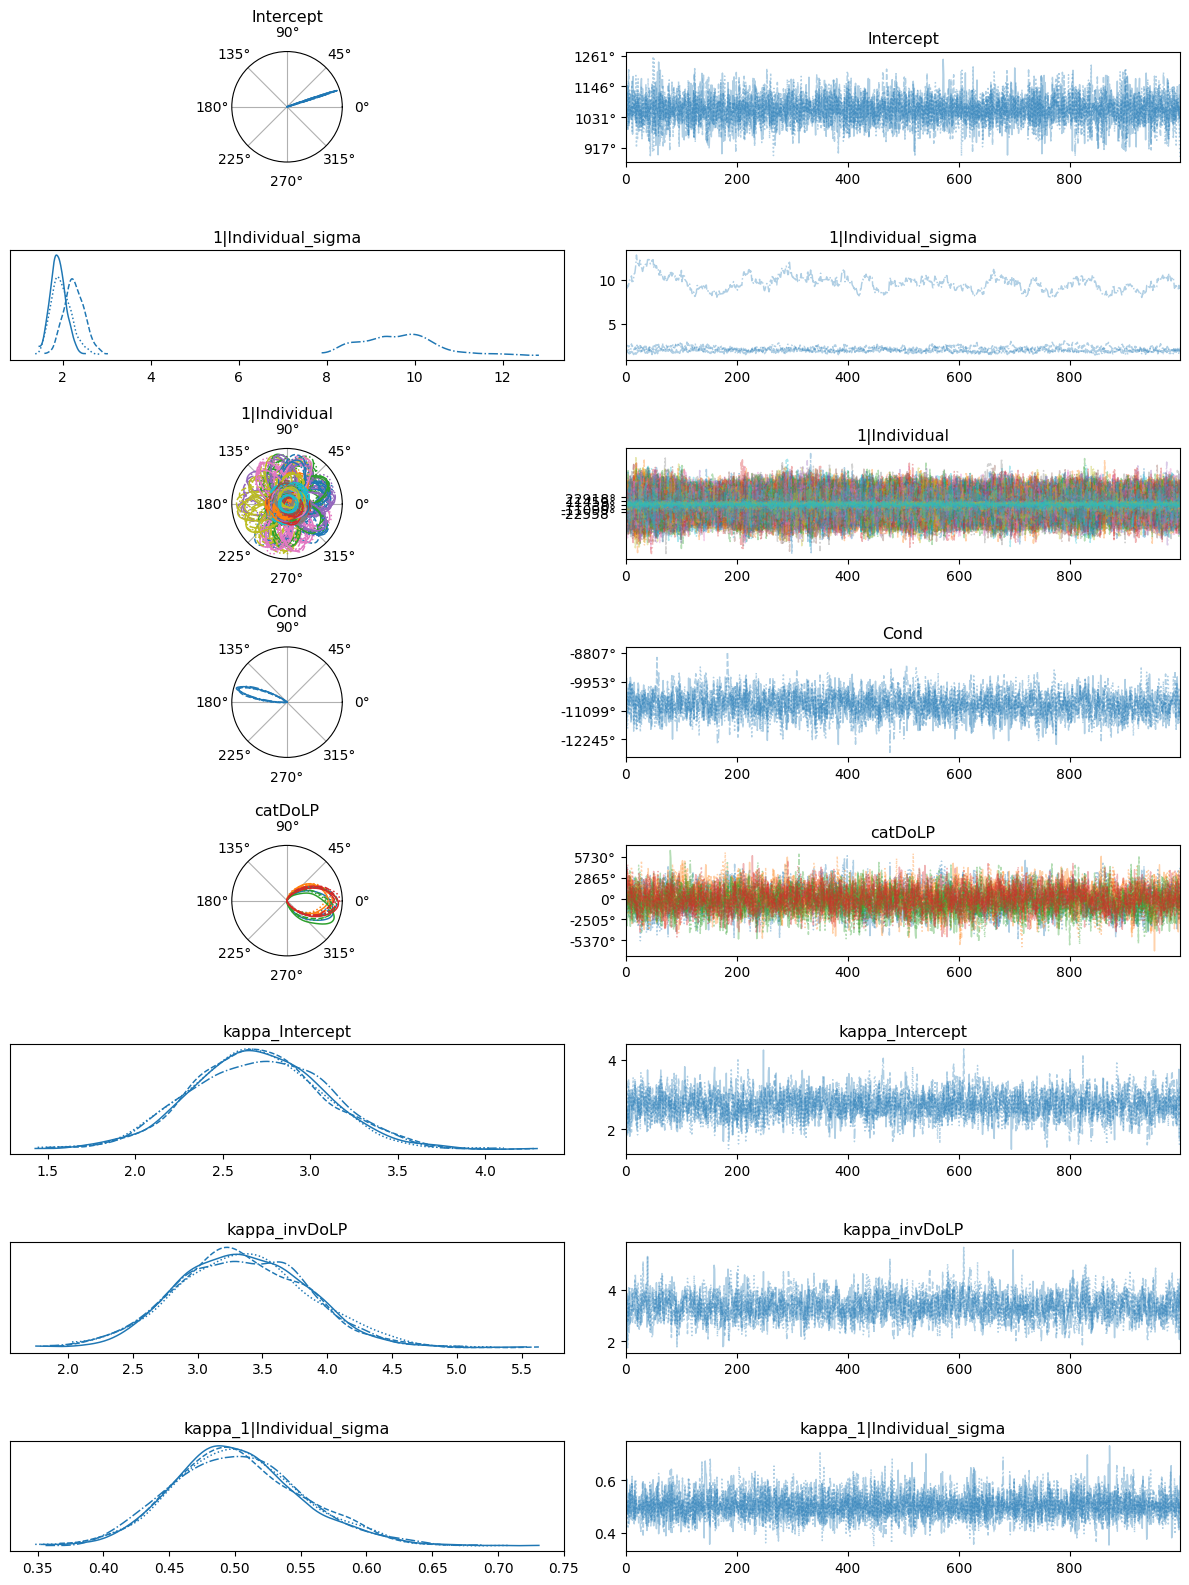

In [13]:
neg_varnms = ["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
               "1|Individual",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_invDoLP",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
neg_cvars = ["Intercept",
             "1|Individual",
            #  "1|Individual_sigma", # fun to plot on a circular scale, but hard to identify problems
                    "Cond",
                    "catDoLP",
        ]
#transform the circular data for interpretability
neg_idata_trans = neg_idata.copy() # set up a variable for transformed data #20250327 somehow linked to old variable!
for cvar in neg_cvars:
    neg_idata_trans.posterior[cvar] = -180*neg_idata.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(neg_idata_trans,
              var_names=neg_varnms,
              circ_var_names=neg_cvars,
              circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model with linear effect of logarithmic-scaled DoLP on doubled angles

In [14]:
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from pymc import VonMises

from scipy.stats import vonmises, circstd


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)

#2nd test, inverse DoLP so that 0 == maximum kappa (potentially easier intercept condition)
df['l10DoLP'] = df['DoLP'].apply(lambda x: np.log10(x)) #intention: 0.99 -> -0.01; 0.02 -> -0.98
#1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
# Use MLE estimates of one condition to find good priors for individual effects (each represents one trial per animal)
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
vm_prior = vonmises.fit(condata["TwoAngle"], fscale=1) #MLE von Mises fit to dist of individuals
sd_prior = circstd(condata["TwoAngle"]) #Mardia SD used as estimate of normal SD

# Define the model formula with updated, capitalized variable names.
# For the angle it might still make more sense to use the categorical DoLP, may not be linear
log_formula = bmb.Formula(
    "TwoAngle ~ Cond + catDoLP + (1|Individual)",
    "kappa ~ l10DoLP + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats, but fixed with normal prior on individual directions
# 2 trials per individual may be insufficient to estimate individual effects in this way
log_priors = {
    # Fixed effects for μ:
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    # Normal version converges smoother
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=1*np.pi/180), 
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=60*np.pi/180), #
    # No expectations about different mean headings by DoLP, beyond a wider spread
    "catDoLP": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180), #could be wider, as 1.0 includes the entire range of DoLP
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # 20250328 noticed multimodality in the posterior, much larger option also found. Try less restrictive?
    # Informative prior used expecting SD close to that measured empirically
    # Using a normal distribution because that converges better
    # "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.07) #This causes the most problems
    "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma = sd_prior/4) #assume zero, but scale by ML estimate
    # "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.1) #assume the ML estimate is correct
    # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(sd_prior), sigma=0.05) #assume the ML estimate is correct
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        #conveniently log10(DoLP == 1.0) = 0.0, so the maximum polarization is the intercept condition
        "l10DoLP": bmb.Prior("Normal", mu=0, sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
log_model = bmb.Model(
    log_formula,
    df,
    family="vonmises",
    priors=log_priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(log_model)

# Fit the model.
# 4000 iterations takes approx 180s
log_idata = log_model.fit(
                draws= 1000,
                tune = 1000,
                init = 'auto',
                progressbar=True) # 

       Formula: TwoAngle ~ Cond + catDoLP + (1|Individual)
                kappa ~ l10DoLP + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 680
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.3222, sigma: 0.0175)
            Cond ~ Normal(mu: 3.1416, sigma: 1.0472)
            catDoLP ~ Normal(mu: 0.0, sigma: 0.5236)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 0.5961))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
            kappa_l10DoLP ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, catDoLP, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_l10DoLP, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics

In [15]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    log_idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_l10DoLP",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    "catDoLP",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                -0.322  0.017  -0.354   -0.291      0.000    0.000   
1|Individual_sigma        2.425  0.540   1.637    3.504      0.232    0.174   
Cond[1.5707963267948966] -2.929  0.144   3.102   -2.642      0.007    0.005   
catDoLP[0.32]             0.123  0.537  -0.968    1.056      0.039    0.100   
catDoLP[0.11]            -0.039  0.537  -1.032    0.963      0.019    0.015   
catDoLP[0.04]             0.069  0.540  -0.950    1.079      0.018    0.008   
catDoLP[0.02]            -0.009  0.516  -1.005    0.932      0.004    0.007   
kappa_Intercept           2.623  0.347   2.015    3.304      0.009    0.007   
kappa_l10DoLP             2.661  0.501   1.762    3.622      0.019    0.013   
kappa_1|Individual_sigma  0.506  0.051   0.419    0.606      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   6889.0    2897.0   1.00  
1|Individual_sigma             6.0      33.0   1.69  
Cond[1.5707963267948966]     420.0    2162.0   1.02  
catDoLP[0.32]                 15.0      42.0   1.19  
catDoLP[0.11]                620.0    1281.0   1.00  
catDoLP[0.04]               2632.0    2661.0   1.00  
catDoLP[0.02]               2738.0    3035.0   1.00  
kappa_Intercept             1423.0    2642.0   1.00  
kappa_l10DoLP                700.0    1756.0   1.01  
kappa_1|Individual_sigma    7490.0    3031.0   1.00

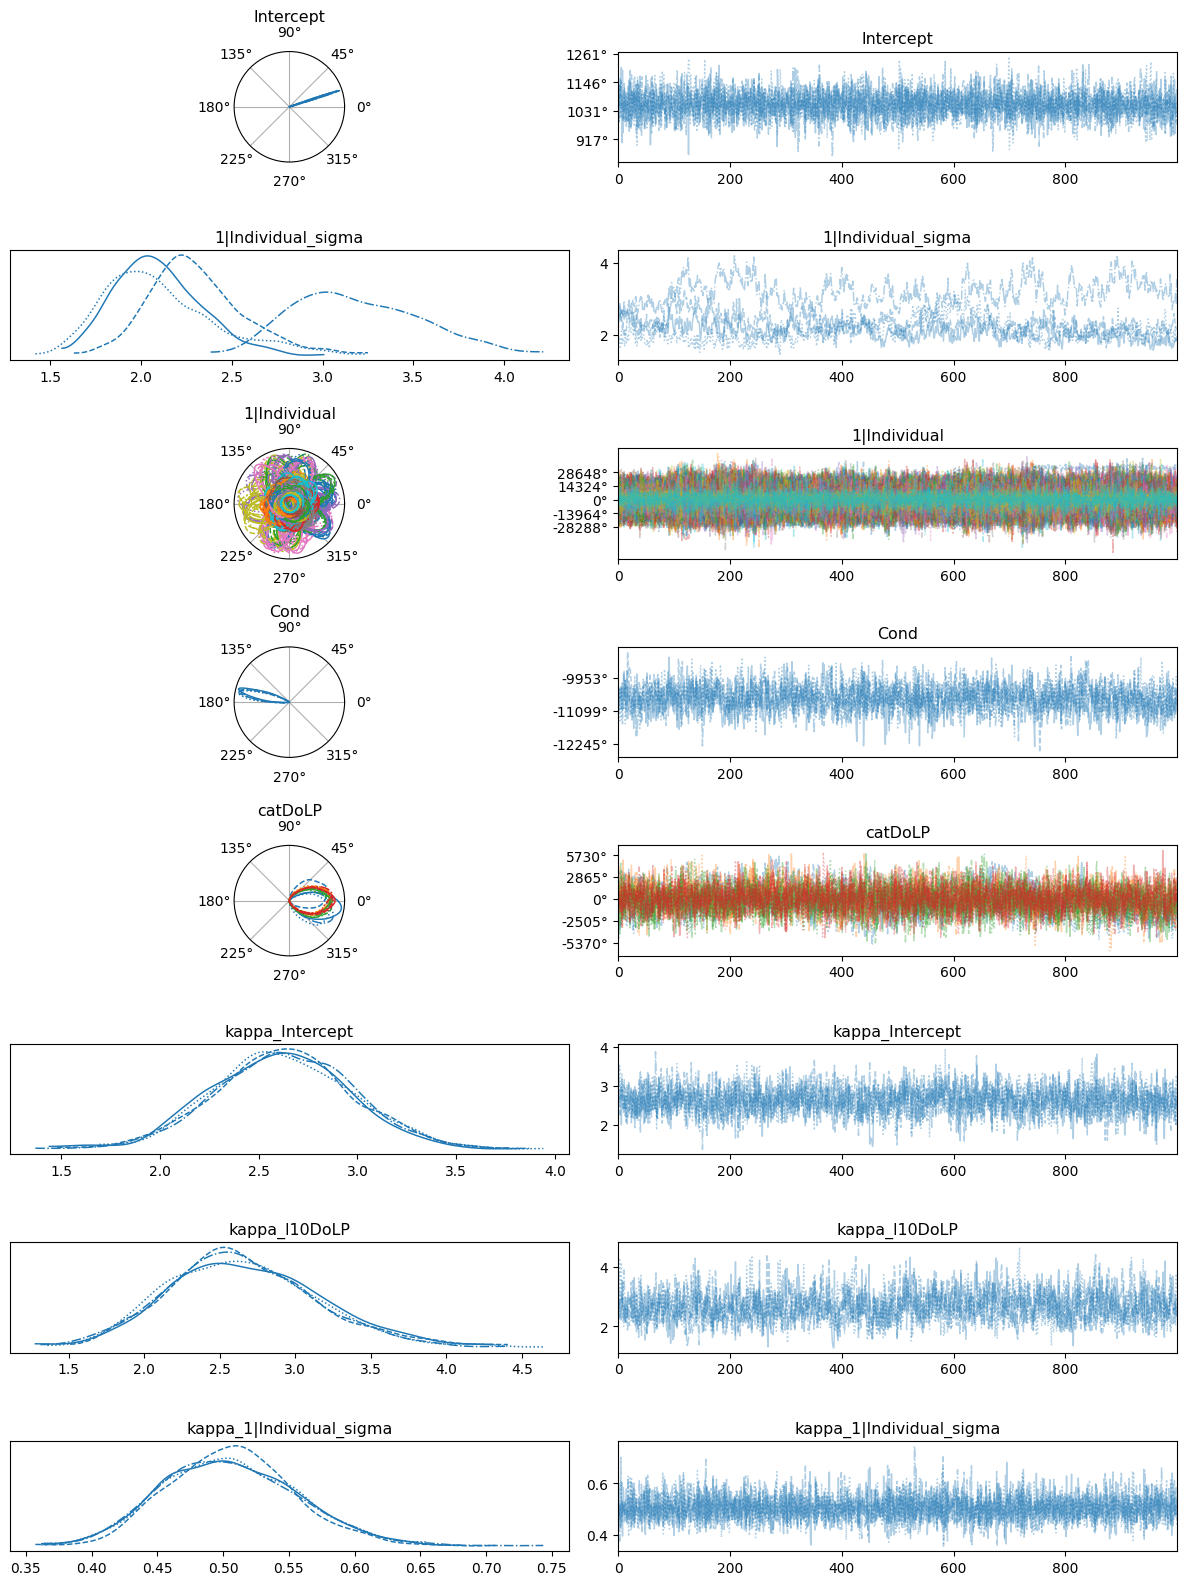

In [16]:
log_varnms = ["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
               "1|Individual",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_l10DoLP",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
log_cvars = ["Intercept",
             "1|Individual",
            #  "1|Individual_sigma", # fun to view on circular scale, as is an angle but not periodic
                    "Cond",
                    "catDoLP",
        ]
#transform the circular data for interpretability
log_idata_trans = log_idata.copy() # set up a variable for transformed data #20250327 somehow linked to old variable!
for cvar in log_cvars:
    log_idata_trans.posterior[cvar] = -180*log_idata.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(log_idata_trans,
              var_names=log_varnms,
              circ_var_names=log_cvars,
              circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model with linear effects on logit scaled DoLP

In [17]:
#This model still needs some work!
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from pymc import VonMises

from scipy.stats import vonmises, circstd
from scipy.special import logit


#1st test, doubled angles as in Foster et al., 2019
df['TwoAngle'] = df['RadAngle'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)

#3rd test, logit DoLP +c so that 0 == maximum kappa (potentially easier intercept condition)
# df['logitDoLP'] = df['DoLP'].apply(lambda x: logit(x)-4.6) #intention: 0.99 -> -0.005; 0.02 -> -8.49
df['logitDoLP'] = df['DoLP'].apply(lambda x: logit(x)) #Using raw logit it much cleaner!
#1st test, condition as a categorical 
df['Cond'] = df['PolAngle_rad'].astype('category')
# Use MLE estimates of one condition to find good priors for individual effects (each represents one trial per animal)
condata = df[df['Cond'] == 0 ] #just the data for polarizer to the North, expect a change of +-90° (x2 = 180°) for polarizer East
vm_prior = vonmises.fit(condata["TwoAngle"], fscale=1) #MLE von Mises fit to dist of individuals
sd_prior = circstd(condata["TwoAngle"]) #Mardia SD used as estimate of normal SD

# Define the model formula with updated, capitalized variable names.
lgt_formula = bmb.Formula(
    "TwoAngle ~ Cond + catDoLP + (1|Individual)",
    "kappa ~ logitDoLP + (1|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#20250327 a lot of divergences and high rhats, but fixed with normal prior on individual directions
# 2 trials per individual may be insufficient to estimate individual effects in this way
lgt_priors = {
    # Fixed effects for μ:
    # It is difficult to find the mean of uniformly distributed individual headings, may be better to anchor it
    # Normal version converges smoother
    "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=1*np.pi/180), #widened to reduce divergences
    # We expect the effect of condition to be a change of 180° (2 x 90°), most priors find this fairly well
    "Cond": bmb.Prior("Normal", mu=np.pi, sigma=60*np.pi/180), #
    # No expectations about different mean headings by DoLP, beyond a wider spread
    "catDoLP": bmb.Prior("Normal", mu=0, sigma=30*np.pi/180), #needs to be restricted for logit scale
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # 20250328 noticed multimodality in the posterior, much larger option also found. Try less restrictive?
    # Informative prior used expecting SD close to that measured empirically
    # Using a normal distribution because that converges better
    # "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.07) #allows negative!
    "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma = sd_prior/4) #assume zero, but scale by ML estimate
    # "Normal", mu=0, sigma=bmb.Prior("StudentT", nu = 3, mu=sd_prior, sigma = 0.1) #assume the ML estimate is correct
    # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(sd_prior), sigma=0.07) #assume the ML estimate is correct
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(10), sigma=1.0), 
        #conveniently log10(DoLP == 1.0) = 0.0, so the maximum polarization is the intercept condition
        "logitDoLP": bmb.Prior("Normal", mu=0, sigma=1.0), 
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1) #Informative prior, individual differences in concentration are small
        ),
    },
}

# Build the model using the updated formula and priors.
lgt_model = bmb.Model(
    lgt_formula,
    df,
    family="vonmises",
    priors=lgt_priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(lgt_model)

# Fit the model.
# 4000 iterations takes approx 180s
lgt_idata = lgt_model.fit(
                draws= 1000,
                tune = 1000,
                init = 'auto',
                progressbar=True) # 

       Formula: TwoAngle ~ Cond + catDoLP + (1|Individual)
                kappa ~ logitDoLP + (1|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 680
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -0.3222, sigma: 0.0175)
            Cond ~ Normal(mu: 3.1416, sigma: 1.0472)
            catDoLP ~ Normal(mu: 0.0, sigma: 0.5236)
        
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 0.5961))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 10.0, sigma: 1.0)
            kappa_logitDoLP ~ Normal(mu: 0.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Cond, catDoLP, 1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_logitDoLP, kappa_1|Individual_sigma, kappa_1|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 316 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics

In [18]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    lgt_idata, 
    var_names=["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_logitDoLP",
               "kappa_1|Individual_sigma",
                ],
    circ_var_names=["Intercept",
                    "Cond",
                    "catDoLP",
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                -0.322  0.018  -0.355   -0.290      0.000    0.000   
1|Individual_sigma        4.416  3.804   1.598   11.795      1.874    1.432   
Cond[1.5707963267948966] -2.885  0.149   3.128   -2.608      0.004    0.003   
catDoLP[0.32]             0.010  0.515  -0.956    0.946      0.022    0.024   
catDoLP[0.11]            -0.040  0.556  -1.113    0.965      0.029    0.018   
catDoLP[0.04]             0.113  0.550  -0.927    1.102      0.028    0.019   
catDoLP[0.02]             0.024  0.493  -0.875    0.963      0.010    0.013   
kappa_Intercept           0.923  0.237   0.477    1.353      0.007    0.005   
kappa_logitDoLP           0.372  0.069   0.242    0.499      0.002    0.001   
kappa_1|Individual_sigma  0.500  0.050   0.404    0.592      0.001    0.000   

                          ess_bulk  ess_tail  r_hat  
Intercept                   9654.0    2988.0   1.00  
1|Individual_sigma             5.0      28.0   2.07  
Cond[1.5707963267948966]    1638.0    2663.0   1.00  
catDoLP[0.32]                235.0     719.0   1.01  
catDoLP[0.11]                480.0     942.0   1.01  
catDoLP[0.04]                376.0    2119.0   1.02  
catDoLP[0.02]                719.0    1842.0   1.00  
kappa_Intercept             1251.0    1889.0   1.00  
kappa_logitDoLP             1326.0    2230.0   1.00  
kappa_1|Individual_sigma    7779.0    2854.0   1.00

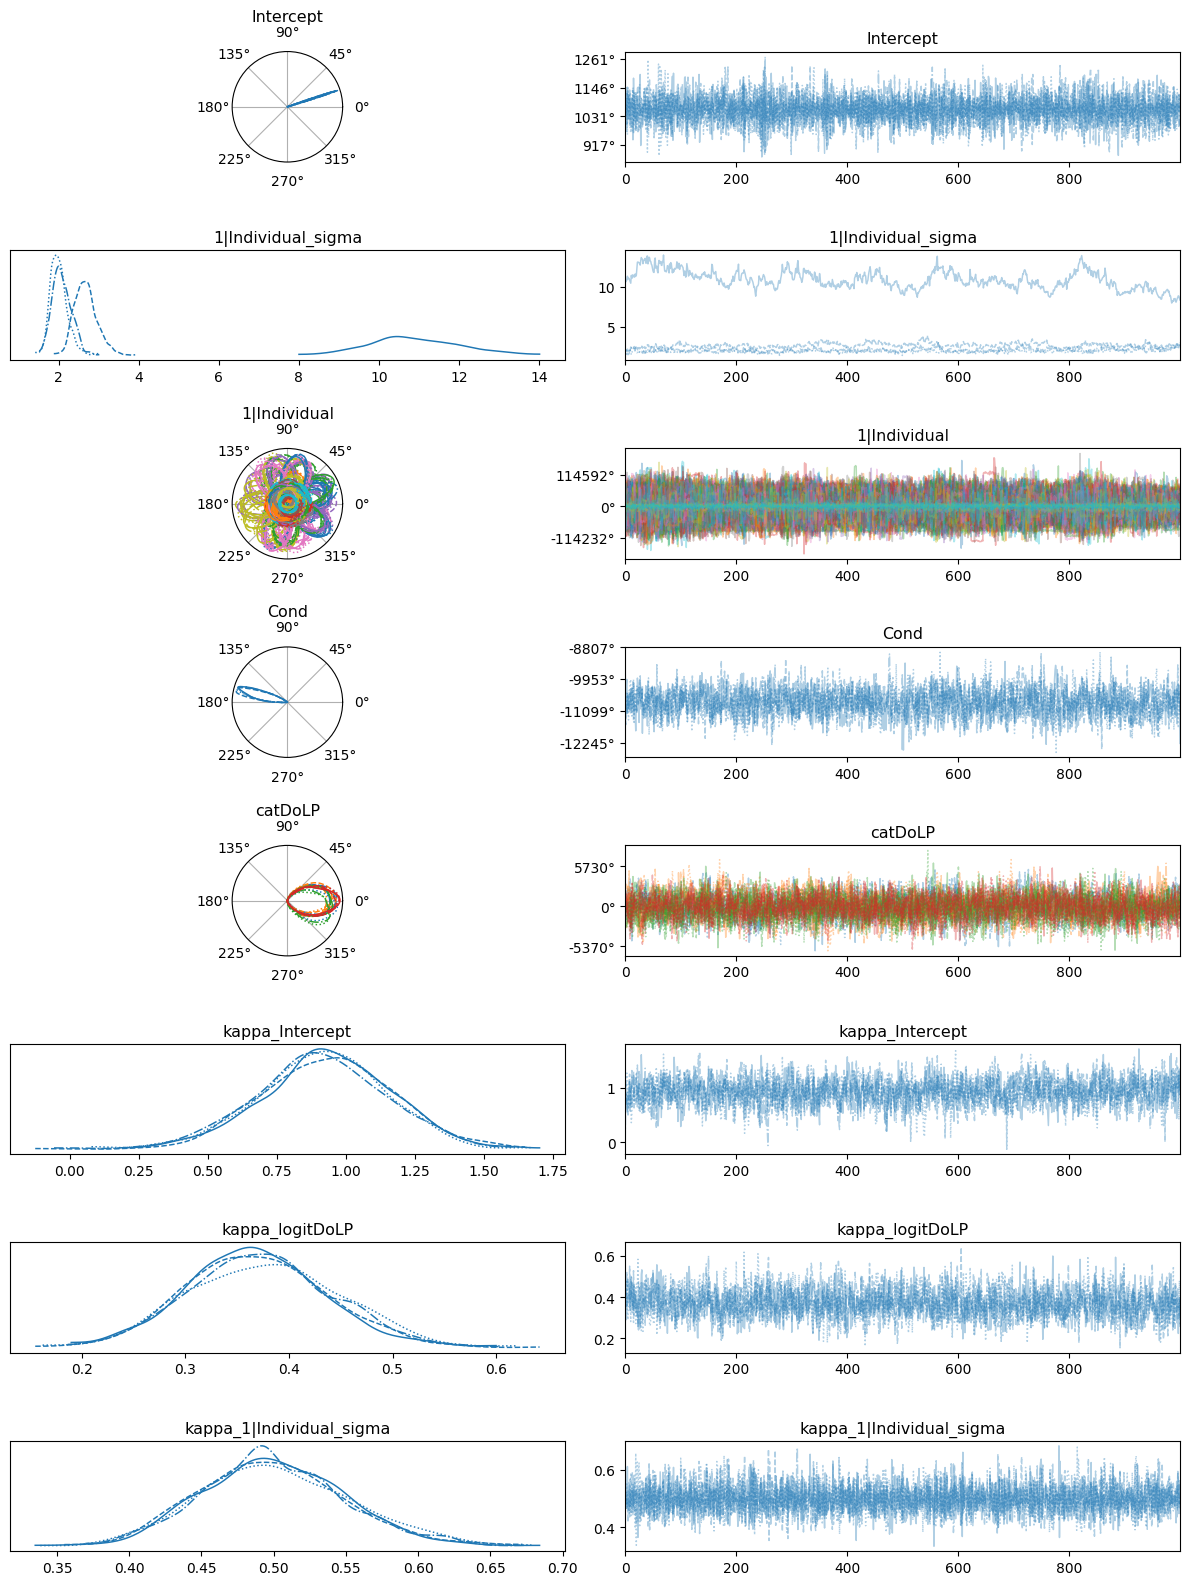

In [19]:
lgt_varnms = ["Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
               "1|Individual",
                "Cond",
                "catDoLP",
                "kappa_Intercept",
                "kappa_logitDoLP",
               "kappa_1|Individual_sigma",
                ]
#Specify which parameters are circular
lgt_cvars = ["Intercept",
             "1|Individual",
            #  "1|Individual_sigma", # fun to view on circular scale, as is an angle but not periodic
                    "Cond",
                    "catDoLP",
        ]
#transform the circular data for interpretability
lgt_idata_trans = lgt_idata.copy() # set up a variable for transformed data #20250327 somehow linked to old variable!
for cvar in lgt_cvars:
    lgt_idata_trans.posterior[cvar] = -180*lgt_idata.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(lgt_idata_trans,
              var_names=lgt_varnms,
              circ_var_names=lgt_cvars,
              circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model used in Foster et al., 2019
The original paper used doubled angles and the "tan half" link. While the link is inadvisable, the rest of the model can be replicated here.

In [20]:
#help with progressbar on Mac?
# https://discourse.pymc.io/t/progress-bar-not-showing-in-pymc3-3-11-1/6898/4
from fastprogress import fastprogress
fastprogress.printing = lambda: True
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from pymc import VonMises


#3rd test, 2019 version. The control stimulus was subtracted, so that relDoLP predicts change relative to the control.
df['relDoLP'] = df['DoLP'].apply(lambda x: np.log10(x) - np.log10(0.02)) #intention: 0.99 -> 1.70; 0.02 -> 0.00
#Remove the effect of the polarizer rotation by subtracting the angle
df['relRad'] = df['RadAngle'] - df['PolAngle_rad']
#Doubled angles as in Foster et al., 2019
df['relTwoAngle'] = df['relRad'].apply(lambda x: shifted_modulo(x*2) if pd.notnull(x) else x)

# Define the model formula with updated, capitalized variable names.
# In the original version the experimental night and trial were also predictors of kappa.
# Since different DoLP values were also used on different nights (though all included a 0.02 condition), this may be difficult to estimate
# The intercept was removed for angles, presumably forcing a model centred on 0°
JEB_formula = bmb.Formula(
    "relTwoAngle ~ 0 + (1|Individual)",
    "kappa ~ relDoLP + Trial + (1|Night)",
)

# Specify priors for the model with capitalized keys and updated variable names.
#BRMS priors for the 2019 model
#                  prior     class      coef     group resp  dpar nlpar bound       source
#      normal(0, 10^0.3)         b                          kappa                (unknown)
#      normal(0, 10^0.3)         b  DoPlog10                kappa             (vectorized)
#       normal(5.0, 0.8) Intercept                          kappa                (unknown)
#    student_t(3, 0, 10)        sd                                               (unknown)
#  student_t(10^2, 0, 1)        sd                          kappa                (unknown)
#    student_t(3, 0, 10)        sd                 ind                        (vectorized)
#    student_t(3, 0, 10)        sd Intercept       ind                        (vectorized)
#  student_t(10^2, 0, 1)        sd               night      kappa             (vectorized)
#  student_t(10^2, 0, 1)        sd Intercept     night      kappa             (vectorized)
#  student_t(10^2, 0, 1)        sd           trial_num      kappa             (vectorized)
#  student_t(10^2, 0, 1)        sd Intercept trial_num      kappa             (vectorized)
JEB_priors = {
    # Fixed effects for μ:
    # "Intercept": bmb.Prior("Normal", mu=vm_prior[1], sigma=1*np.pi/180), #No intercept?
    # Individual-level effects for μ: #bias to high kappa appears to cause divergent transitions here
    "1|Individual": bmb.Prior(
    # In these experiments, we have no expectation that beetles would choose the same direction in their 1st trial
    # "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma = 10) #This causes the most problems
    "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma = 45*np.pi/180) #Without the halftan link, needs to be tighter
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # # Across two trials the MLE for this should range from ≈1.5–2.8
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(5.0), sigma=0.8), 
        #for relDoLP (DoLP == 0.02) = 0.0, so the minimum polarization is the intercept condition
        "relDoLP": bmb.Prior("Normal", mu=0, sigma=2.0), 
        #Expect no effect of trial on precision (might decrease with trials, but near impossible to detect)
        "Trial": bmb.Prior("HalfStudentT", nu=100, sigma=1.0), 
        # Individual-level effects for κ:
        # Presumably the large number of df for this Student T was to narrow the distribution
        "1|Night": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu=100, sigma=1.0) #
        ),
    },
}

# Build the model using the updated formula and priors.
JEB_model = bmb.Model(
    JEB_formula,
    df,
    family="vonmises",
    priors=JEB_priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
    
)

print(JEB_model)

# Fit the model.
# 4000 iterations takes approx 180s
# 2019 paper used 4000 draws
JEB_idata = JEB_model.fit(
                draws= 1000,
                tune = 1000,
                init = 'auto',
                progressbar=True) #
#Some divergent transitions, though not as many as might be expected for these priors 

       Formula: relTwoAngle ~ 0 + (1|Individual)
                kappa ~ relDoLP + Trial + (1|Night)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 680
        Priors: 
    target = mu
        Group-level effects
            1|Individual ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 3.0, sigma: 0.7854))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 4.9932, sigma: 0.8)
            kappa_relDoLP ~ Normal(mu: 0.0, sigma: 2.0)
            kappa_Trial ~ HalfStudentT(nu: 100.0, sigma: 1.0)
        
        Group-level effects
            kappa_1|Night ~ Normal(mu: 0.0, sigma: HalfStudentT(nu: 100.0, sigma: 1.0))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|Individual_sigma, 1|Individual_offset, kappa_Intercept, kappa_relDoLP, kappa_Trial, kappa_1|Night_sigma, kappa_1|Night_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 165 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


## Check convergence heuristics
BRMS version from 2019
>   Family: von_mises 

>  Links: mu = tan_half; kappa = log 

>   Formula: rad ~ 0 + (1 | ind) ;
>kappa ~ DoPlog10 + (1 | night) + (1 | trial_num)

>   Data: data201611 (Number of observations: 680) 

>   Draws: 4 chains, each with iter = 4000; warmup = 2000; thin = 1;
>         total post-warmup draws = 8000

Multilevel Hyperparameters:
 ~ind (Number of levels: 340) 

| coef | Estimate | Est.Error | l-95% CI | u-95% CI | Rhat | Bulk_ESS | Tail_ESS |
| :------ | :------: | :------: | :------: | :------: | :------: | :------: | :------: |
| sd(Intercept) | 1.92 | 0.33 | 1.42 | 2.68 | 1.00 | 1749 | 2291 |


 ~night (Number of levels: 5) 

| coef | Estimate | Est.Error | l-95% CI | u-95% CI | Rhat | Bulk_ESS | Tail_ESS |
| :------ | :------: | :------: | :------: | :------: | :------: | :------: | :------: |
| sd(kappa_Intercept)    |      0.46   |    0.44      |    0.02     |    1.66     |   1.00  |   1170      |     2471    |
                                

 ~trial_num (Number of levels: 2) 

| coef | Estimate | Est.Error | l-95% CI | u-95% CI | Rhat | Bulk_ESS | Tail_ESS |
| :------ | :------: | :------: | :------: | :------: | :------: | :------: | :------: |
| sd(kappa_Intercept) | 2.64 | 0.60 | 1.59 | 3.95 | 1.00 | 5083 | 4595 |

Regression Coefficients:
| coef | Estimate | Est.Error | l-95% CI | u-95% CI | Rhat | Bulk_ESS | Tail_ESS |
| :------ | :------: | :------: | :------: | :------: | :------: | :------: | :------: |
| kappa_Intercept | 3.26 | 0.85 | 1.55 | 4.92 | 1.00 | 6502 | 5226 |
| kappa_DoPlog10 | 1.42 | 0.55 | 0.58 | 2.73 | 1.01 | 888 | 2082 |


Draws were sampled using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [21]:
#check convergence heuristics
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    JEB_idata, 
    var_names=[#"Intercept",
            #    "1|Individual_kappa",
               "1|Individual_sigma",
                "kappa_Intercept",
                "kappa_relDoLP",
                "kappa_Trial",
               "kappa_1|Night_sigma",
                ],
    circ_var_names=[
                    ]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|Individual_sigma   2.265  0.375   1.679    3.015      0.099    0.072   
kappa_Intercept      3.311  0.855   1.714    4.887      0.019    0.013   
kappa_relDoLP        1.326  0.459   0.496    2.195      0.016    0.011   
kappa_Trial          0.238  0.226   0.000    0.672      0.006    0.005   
kappa_1|Night_sigma  3.142  0.673   1.894    4.379      0.015    0.011   

                     ess_bulk  ess_tail  r_hat  
1|Individual_sigma       17.0      30.0   1.17  
kappa_Intercept        2025.0    2132.0   1.00  
kappa_relDoLP           845.0    1314.0   1.00  
kappa_Trial            1968.0    1330.0   1.00  
kappa_1|Night_sigma    1972.0    2235.0   1.00

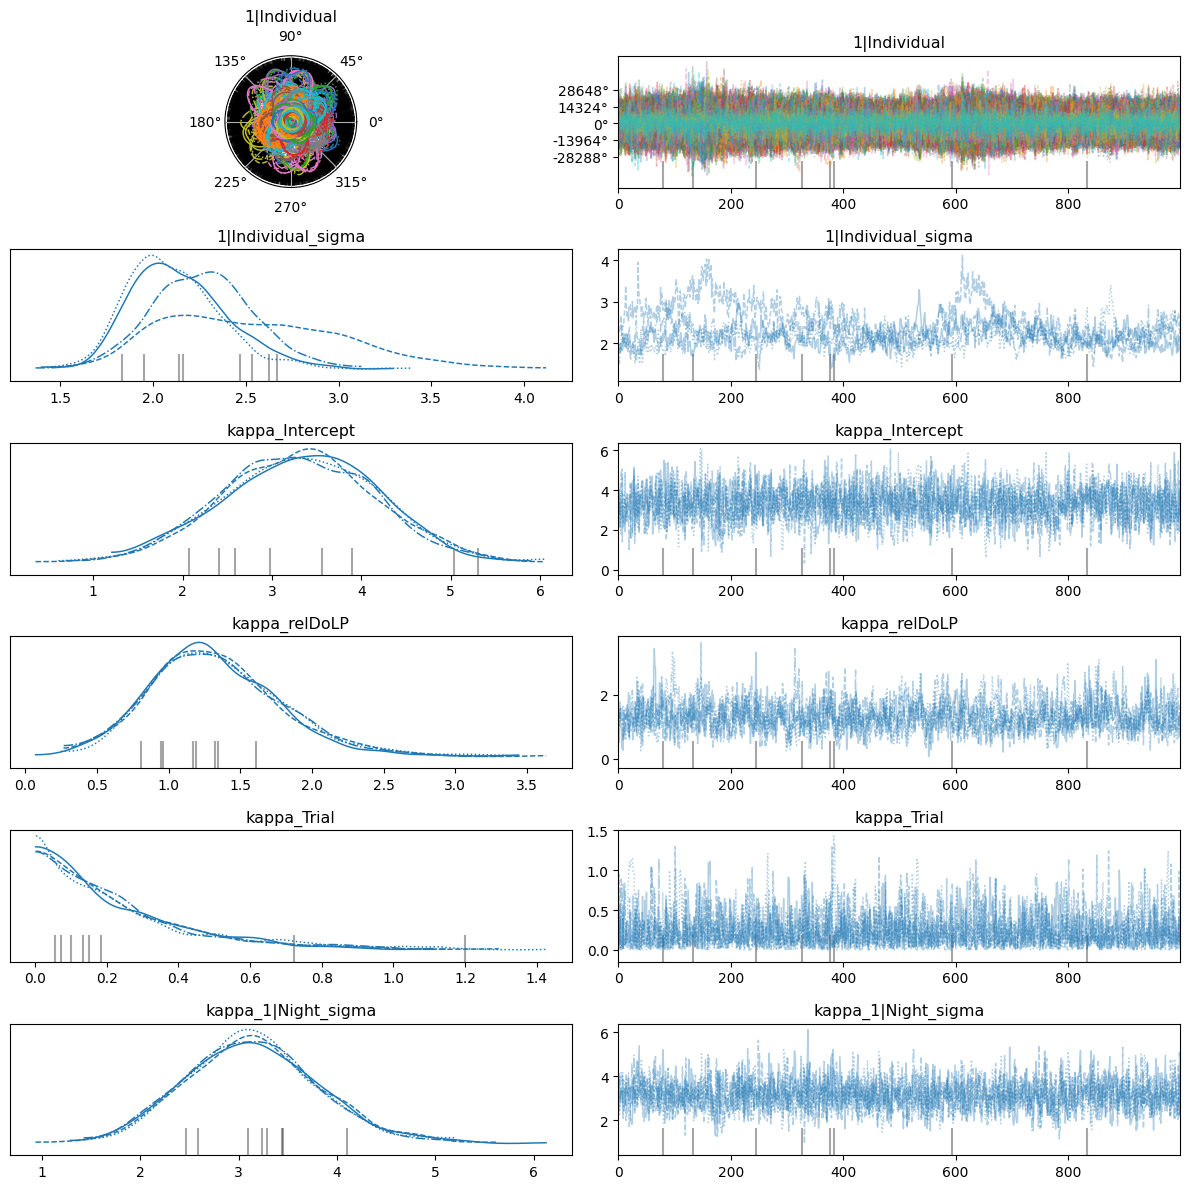

In [22]:
JEB_varnms = [
              "1|Individual",
                "1|Individual_sigma",
                "kappa_Intercept",
                "kappa_relDoLP",
                "kappa_Trial",
               "kappa_1|Night_sigma"
                ]
# #Specify which parameters are circular
JEB_cvars = [
             "1|Individual"
            ]
# #transform the circular data for interpretability
JEB_idata_trans = JEB_idata.copy() # set up a variable for transformed data #20250327 somehow linked to old variable!
for cvar in JEB_cvars:
    JEB_idata_trans.posterior[cvar] = -180*JEB_idata.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(JEB_idata_trans,
              var_names=JEB_varnms,
              circ_var_names=JEB_cvars,
              circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Compare Doubled-Angle models
Use leave-one-out cross validation (LOO-CV) to compare model predictions.

In [23]:
#TODO fix, no longer working
#     240 # Collect coordinates from all the likelihood parameters
# --> 241 params_coords = xr.Coordinates()
# module 'xarray' has no attribute 'Coordinates'

#First the log likelihood function needs to be computed for each model and dataset
cat_model.compute_log_likelihood(cat_idata)
neg_model.compute_log_likelihood(neg_idata)
log_model.compute_log_likelihood(log_idata)
lgt_model.compute_log_likelihood(lgt_idata)
JEB_model.compute_log_likelihood(JEB_idata)

#Calculate predictive power using LOO cross-validation
loo_cat = az.loo(cat_idata)
loo_neg = az.loo(neg_idata)
loo_log = az.loo(log_idata)
loo_lgt = az.loo(lgt_idata)
loo_JEB = az.loo(JEB_idata)

#print the results
print('\n----- Categorical -----\n')
print(loo_cat)
print('\n----- Linear -----\n')
print(loo_neg)
print('\n----- Logarithmic -----\n')
print(loo_log)
print('\n----- Logit scaled -----\n')
print(loo_lgt)
print('\n----- Original -----\n')
print(loo_JEB)
#some warnings in a small proportion of cases, but predictions are generally accurate

#compare, ranking models from best to worst
az.compare({'Categorical':loo_cat,
            'Linear':loo_neg,
            'Logarithmic':loo_log,
            'Logit scaled':loo_lgt, 
            'Original':loo_JEB
            }, 
            ic="loo")

KeyboardInterrupt: 

# Attempt Bimodal Model
This may be difficult to achieve in Bambi. For `pymc` version see: 
[Sayin $et~al$. 2025](https://github.com/jgraving/sayin_locust_mixture_model/blob/main/locust_mixture_model.ipynb)
Here I will try using a Bambi [custom family](https://bambinos.github.io/bambi/api/Family.html#bambi.Family).

In [108]:
from unwrap.link.numpy import inverse_softplus
import pymc as pm
import pytensor.tensor as pt

## prepare the data
#vector of angles for pymc
directions = df['RadAngle'].values

## convert from names to numbers
# individuals = df['Individual'].values.astype(np.int32)
individuals, uniques = pd.factorize(df['Individual'])#returns the index in the unique values vector, and the unique values vector
## pymc will only accept integers, convert tuple to integer entrywise
individuals = pd.Series(individuals).apply(lambda x: np.int32(x))
num_individuals = df['Individual'].nunique()
#Polarizer orientation as 0 or 1
cond, uu = pd.factorize(df['Cond'])
## pymc will only accept integers, convert tuple to integer entrywise
cond = pd.Series(cond).apply(lambda x: np.int32(x))
# Degree of Linear Polarization as 0,1,2,3,4
catDoLP, uu = pd.factorize(df['catDoLP'])
## pymc will only accept integers, convert tuple to integer entrywise
catDoLP = pd.Series(catDoLP).apply(lambda x: np.int32(x))
# log10 Degree of Linear Polarization as a number between -1.7 and 0.0
l10DoLP = df['l10DoLP'].apply(lambda x: np.float32(x))

disp_d = {'cond': cond.values,
                     'DoLP': catDoLP.values,
                     'log10_DoLP': l10DoLP.values,
                     'ID': individuals}
# pd.DataFrame(data = disp_d).describe()
pd.DataFrame(data = disp_d).head()

cond  DoLP  log10_DoLP  ID
0     0     0   -0.004365   0
1     0     1   -1.698970   1
2     1     0   -0.004365   2
3     1     1   -1.698970   3
4     0     0   -0.004365   4

In [ ]:
#should be equivalent to     
# "RadAngle ~ Cond + catDoLP + (1|Individual)",
# "kappa ~ l10DoLP + (1|Individual)",
#This was not generating variations of mean direction, revisiting
with pm.Model() as hyper_directional_model:

    # Population mean angle in radians, bounded between -π and π
    # mu_pop_unsorted = pm.Uniform("mu_pop_unsorted", lower=-np.pi, upper=np.pi, shape=(2,))
    # pymc has trouble finding this on its own, giving a better prior
    mu_pop_unsorted = pm.Normal("mu_pop_unsorted", 
                                mu=vm_prior[1]/2 + [0, np.pi], 
                                sigma = 5*np.pi/180, #relatively narrow
                                shape=(2,)
                                )
    mu_pop = pm.Deterministic("mu_pop", pt.sort(mu_pop_unsorted))

    #Effect of polarizer position (0 = East, 1 = North)
    mu_cond = pm.Normal("mu_cond",
                        mu=np.pi,
                        sigma=60*np.pi/180,
                        shape = (1,)#this rotation only acts once
                        )
    #We expect the individual means to be similar, but there is a strong possibilty of low agreement
    #this is a difficult prior to set
    #a bias towards zero seems reasonable, but where large variation is present larger values around 60° may fit data better
    mu_sigma = pm.Lognormal('mu_sigma', 
                            # mu = np.log(5*np.pi/180), #sd roughly equivalent to kappa = 100 but strong tails
                            #    sigma = 1.5) #wide tails
                            mu = np.log(20*np.pi/180), #sd roughly equivalent to kappa = 10 but strong tails
                               sigma = 0.5) #wide tails
    # Individual mean angles with a normal distribution, adjusted by the population mean
    mu_unsorted = pm.Normal("mu_unsorted", 
                                mu = 0, 
                                sigma=mu_sigma, #the standard deviation of the set of individuals, in radians
                                shape=(num_individuals, 2)
                                ) + mu_pop_unsorted + mu_cond#broadcast to the same shape through addition
    
    
    mu = pm.Deterministic("mu", pt.sort(mu_unsorted))

    # Population kappa values with a softplus transformation for non-negativity
    #expectation of high agreement within individuals
    kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(10.0), sigma = 10.0, shape=(2,))
    #effect of DoLP on kappa
    #conveniently log10(DoLP == 1.0) = 0.0, so the maximum polarization is the intercept condition
    kappa_l10DoLP = pm.Normal("kappa_l10DoLP", mu=0, sigma=1.0)
    #population kappa
    kappa_pop = pm.Deterministic("kappa_pop",  pt.softplus(kappa_log_pop + kappa_l10DoLP*l10DoLP))

    # Individual kappa values, also transformed for non-negativity
    kappa_log = pm.Normal("kappa_log", mu=0, sigma=0.5, shape=(num_individuals, 2)) + kappa_log_pop
    kappa = pm.Deterministic("kappa", pt.softplus(kappa_log))

    # Population weights with a sigmoid transformation
    weights_logit_pop = pm.Normal("weights_logit_pop", mu=0, sigma=0.5)
    weights_pop = pm.Deterministic("weights_pop", pm.math.sigmoid(pt.stack([weights_logit_pop, -weights_logit_pop], axis=-1)))

    # Individual weights, also transformed with a sigmoid function
    weights_logit = pm.Normal("weights_logit", mu=0, sigma=1.0, shape=(num_individuals,)) + weights_logit_pop
    weights = pm.Deterministic("weights", pm.math.sigmoid(pt.stack([weights_logit, -weights_logit], axis=-1)))

    # Von Mises components for mixture model
    components = pm.VonMises.dist(mu=mu[individuals], kappa=kappa[individuals])

    # Mixture model for observed data (directions)
    pm.Mixture("directions_obs", w=weights[individuals], comp_dists=components, observed=directions)

In [110]:
#takes over one minute to initialise
#less than 7 min for 2000 samples!
with hyper_directional_model:
    trace_hyper = pm.sample(tune = 500,
                            draws = 500, 
                            return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop_unsorted, mu_cond, mu_sigma, mu_unsorted, kappa_log_pop, kappa_log, weights_logit_pop, weights_logit]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 126 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [112]:
## check convergence heuristics on the main effects
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    trace_hyper, 
    var_names=["mu_pop",
            #    "mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
               "mu_cond",#should be approx 1.57
               "mu_sigma",#
                "kappa_pop",
            #    "kappa_log",
               "weights_logit_pop",
            #    "weights_logit"
                ],
    circ_var_names=["mu_pop",
                    # "mu_unsorted"
                    ]
)
#NB mean should be around 60° = 1.05
#mu_sigma is quite close to the equivalent kappa value [  A1inv(exp((0.7^2)/-2)) = 2.7 ]
#kappa_pop is very close to the simulated value skappa

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_pop[0]         -0.160  0.084  -0.320   -0.001      0.001    0.001   
mu_pop[1]          2.980  0.082   2.827    3.131      0.002    0.001   
mu_cond[0]         3.082  0.555   2.010    4.065      0.046    0.033   
mu_cond[1]         3.219  0.494   2.079    4.024      0.043    0.030   
mu_sigma           0.809  0.307   0.339    1.445      0.118    0.090   
kappa_pop[0]       1.175  0.686   0.000    2.194      0.162    0.117   
kappa_pop[1]       1.169  0.685   0.000    2.192      0.139    0.100   
weights_logit_pop  0.008  0.428  -0.724    0.859      0.016    0.011   

                   ess_bulk  ess_tail  r_hat  
mu_pop[0]            2887.0    1252.0   1.00  
mu_pop[1]            2965.0    1601.0   1.00  
mu_cond[0]             71.0      74.0   1.10  
mu_cond[1]            121.0      72.0   1.05  
mu_sigma                8.0      11.0   1.43  
kappa_pop[0]           18.0      25.0   1.15  
kappa_pop[1]           27.0      35.0   1.11  
weights_logit_pop     734.0    1134.0   1.01

In [30]:
## check convergence heuristics on the individual-level effects
#It may not even make sense to try to converge the model without the interaction, since the mu effect  brightness depends strongly on colour
az.summary(
    trace_hyper, 
    var_names=["mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
                "kappa",
               "weights_logit"
                ],
    circ_var_names=[
                    "mu_unsorted"
                    ]
)
#NB mean should be around 60° = 1.05
#mu_kappa is overestimated here, but that may be reasonable with limited data
#kappa_pop is overestimated here, but that may be reasonable with limited data

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_unsorted[0, 0]  -0.449  0.924  -2.178    1.290      0.045    0.115   
mu_unsorted[0, 1]   0.530  0.749  -0.957    1.931      0.024    0.080   
mu_unsorted[1, 0]  -0.218  0.973  -2.016    1.794      0.016    0.107   
mu_unsorted[1, 1]   0.015  0.771  -1.413    1.554      0.006    0.077   
mu_unsorted[2, 0]   0.359  0.645  -0.875    1.588      0.012    0.053   
...                   ...    ...     ...      ...        ...      ...   
weights_logit[335] -0.482  0.940  -2.127    1.413      0.013    0.010   
weights_logit[336] -0.407  0.946  -2.135    1.450      0.012    0.012   
weights_logit[337]  0.428  0.936  -1.320    2.176      0.009    0.010   
weights_logit[338]  0.370  0.957  -1.443    2.156      0.009    0.012   
weights_logit[339] -0.467  0.932  -2.298    1.247      0.013    0.010   

                    ess_bulk  ess_tail  r_hat  
mu_unsorted[0, 0]     4371.0     186.0   1.03  
mu_unsorted[0, 1]     2902.0     407.0   1.02  
mu_unsorted[1, 0]     7706.0     184.0   1.03  
mu_unsorted[1, 1]     9955.0     265.0   1.02  
mu_unsorted[2, 0]     3745.0     287.0   1.02  
...                      ...       ...    ...  
weights_logit[335]    5078.0    4158.0   1.00  
weights_logit[336]    7038.0    4998.0   1.00  
weights_logit[337]    9938.0    5965.0   1.00  
weights_logit[338]   11170.0    5105.0   1.00  
weights_logit[339]    5370.0    5015.0   1.00  

[1700 rows x 9 columns]

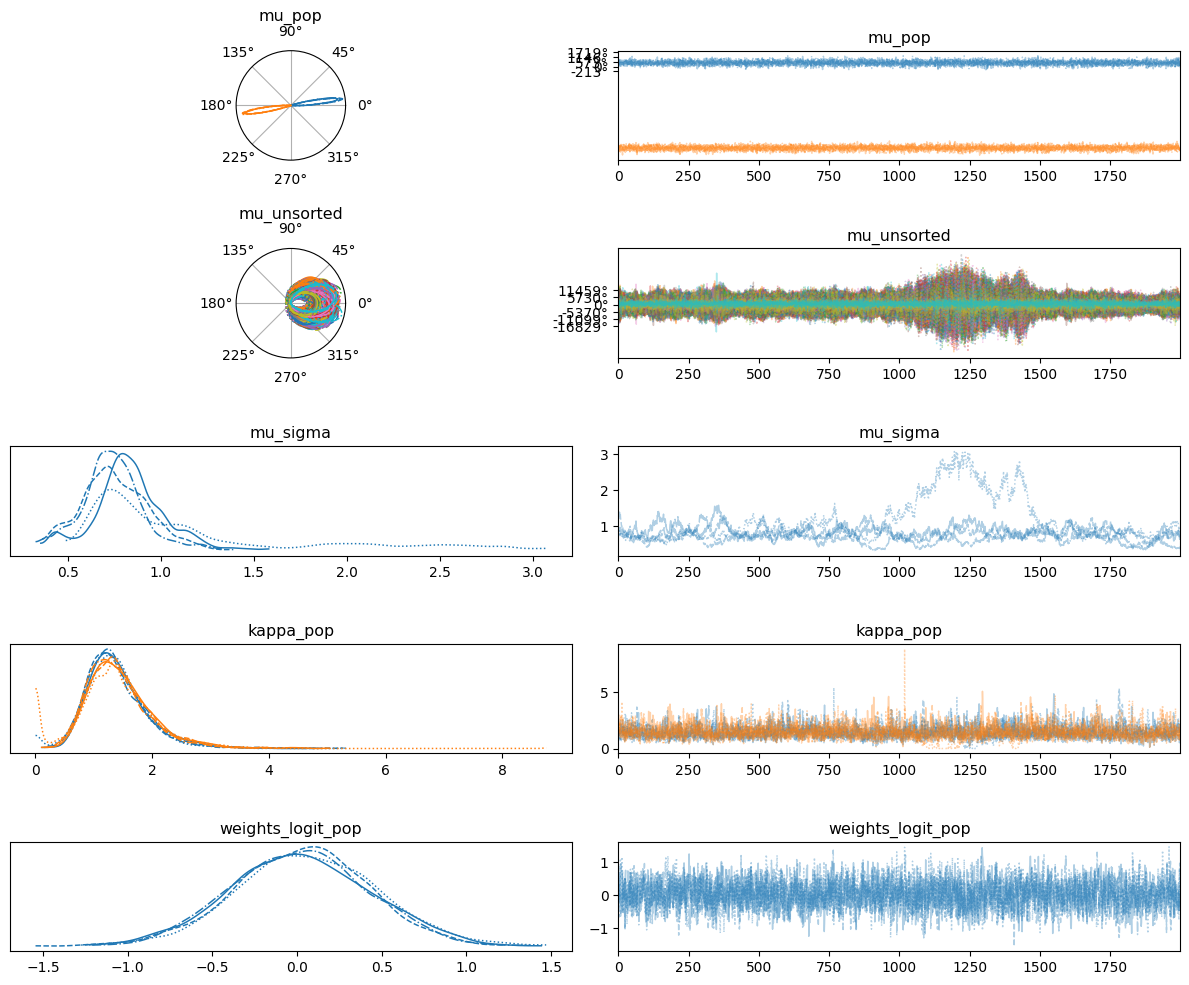

In [31]:
varnms = ["mu_pop",
        #   "mu",
               "mu_unsorted",#there are a lot of these, perhaps don't inspect all immediately
               "mu_sigma",
                "kappa_pop",
            #    "kappa_log",
               "weights_logit_pop",
            #    "weights_logit"
                ]
#Specify which parameters are circular
cvars = ["mu_pop",
        #  "mu",
         "mu_unsorted"
        ]
#transform the circular data for interpretability
trace_hyper_trans = trace_hyper.copy() # set up a variable for transformed data
for cvar in cvars:
    trace_hyper_trans.posterior[cvar] = -180*trace_hyper_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(trace_hyper_trans,
              var_names= varnms,
              circ_var_names=cvars,
              circ_var_units='degrees') #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()